In [1]:
import pickle
import sys
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import zscore
from matplotlib.patches import Rectangle, Patch
import torch


sys.path.insert(0, '../4_preffect')
from _config import configs
from preffect_factory import factory
import anndata as ad 
from _inference import( Inference )

num_processors = 5
torch.set_num_threads(num_processors)
torch.set_num_interop_threads(num_processors)

In [2]:
# Jensen Shannon Divergence
from scipy.spatial import distance

def compute_jsd_scipy(P, Q):
    # Ensure that P and Q are numpy arrays
    P = np.array(P)
    Q = np.array(Q)

    # Normalize the distributions so they sum to 1
    P = P / np.sum(P)
    Q = Q / np.sum(Q)

    # Compute Jensen-Shannon distance
    js_distance = distance.jensenshannon(P, Q)
    
    # Square the Jensen-Shannon distance to get the divergence
    js_divergence = js_distance ** 2
    return js_divergence

# checking to see if not using SciPy is a big deal or not (turns out they're equivalent)
def compute_jsd(P, Q):
    # Convert to numpy arrays
    P = np.array(P, dtype=np.float64)
    Q = np.array(Q, dtype=np.float64)

    # Normalize the distributions
    P /= np.sum(P)
    Q /= np.sum(Q)

    

    # Calculate the average distribution
    M = 0.5 * (P + Q)

    # Replace zeros to avoid log(0)
    epsilon = 1e-10
    P = np.where(P == 0, epsilon, P)
    Q = np.where(Q == 0, epsilon, Q)
    M = np.where(M == 0, epsilon, M)

    # Compute Kullback-Leibler divergences
    KL_P_M = np.sum(P * np.log(P / M))
    KL_Q_M = np.sum(Q * np.log(Q / M))

    # Compute Jensen-Shannon Divergence
    JSD = 0.5 * (KL_P_M + KL_Q_M)
    return JSD



In [ ]:
# Pick file you're going to evaluate

# dataset
dataset_run = "dataset_omega_batch_2_90/L_Million_rprime128"

image_save = "/path/to/3_omega_batch_dataset_run_analysis/" + dataset_run
# Create directory
if not os.path.exists(image_save):
    os.makedirs(image_save)

def list_subfolders(directory):
    subfolders = [entry.name for entry in os.scandir(directory) if entry.is_dir()]
    return subfolders

# created a sorting algorithm to ensure "epoch_100" is sorted after "epoch_50"
def sort_key(s):
    s = re.sub(r'\s+', '', s)
    # Extract the number from the folder name (assuming every folder name has the format 'test_<number>')
    match = re.search(r'\d+$', s)
    if match:
        return int(match.group())
    return s

folder_search = f'/path/to/{dataset_run}'


all_subfolders = sorted(list_subfolders(folder_search), reverse=False)


all_subfolders = all_subfolders[0:5]

print("All sub-folders:", all_subfolders)

All sub-folders: ['Simple_E1000_M100_NB_BatchCorr_NoMCAR_XW2000_KLW01', 'Simple_E1000_M100_NB_BatchCorr_NoMCAR_XW2000_KLW01_2', 'Simple_E1000_M100_NB_BatchCorr_NoMCAR_XW2000_KLW01_3', 'Simple_E1000_M100_NB_BatchCorr_NoMCAR_XW2000_KLW01_4']


In [4]:
# Re-instate the model (models?)
configs['task'] = 'reinstate'

pr_reinstate = {}

for pr_count, dir_name in enumerate(all_subfolders):

    dir_name = re.sub(r'\s+', '', dir_name)
    full_path = folder_search + "/" + dir_name
    configs['output_path'] = full_path
    configs['cuda_device_num'] = 4
    pr_reinstate[pr_count] = factory(task='reinstate', configs=configs, trigger_setup=True)
    
    #configs['input_inference_anndata_path'] = configs['input_anndata_path'] + 'test/' 
    #configs['task'] = 'impute_experiment'
    #infy, error_masked, error_unmasked, df_subtype  = factory(task='impute_experiment', configs=configs, 
    #                                                preffect_obj=pr_reinstate, inference_key = 'endogenous',
    #                                                error_type='mse')

    configs['always_save'] = False


In [ ]:
# Lets see what happens when we set everyone to batch 1
# my thought is there would be no indication that batch is sporatic
pr_count = 0

infy = {}

for pr_count, folder_name in enumerate(all_subfolders):

    configs_inf = pr_reinstate[pr_count].configs.copy()
    configs_inf['task'] = 'inference'

    configs_inf['adjust_vars'] = True

    print("Inferring if all Batch 0...")

    configs_inf['adjust_to_batch_level'] = 0

    infy[pr_count] = factory(task='inference', configs=configs_inf, 
                    preffect_obj=pr_reinstate[pr_count], inference_key = 'test')


    #print("Inferring if all Batch 1...")
    #configs_inf['adjust_to_batch_level'] = 1
    #infy[pr_count] = factory(task='inference', configs=configs_inf, 
    #                preffect_obj=pr_reinstate[pr_count], inference_key = 'test')

Inference Type:  endogenous


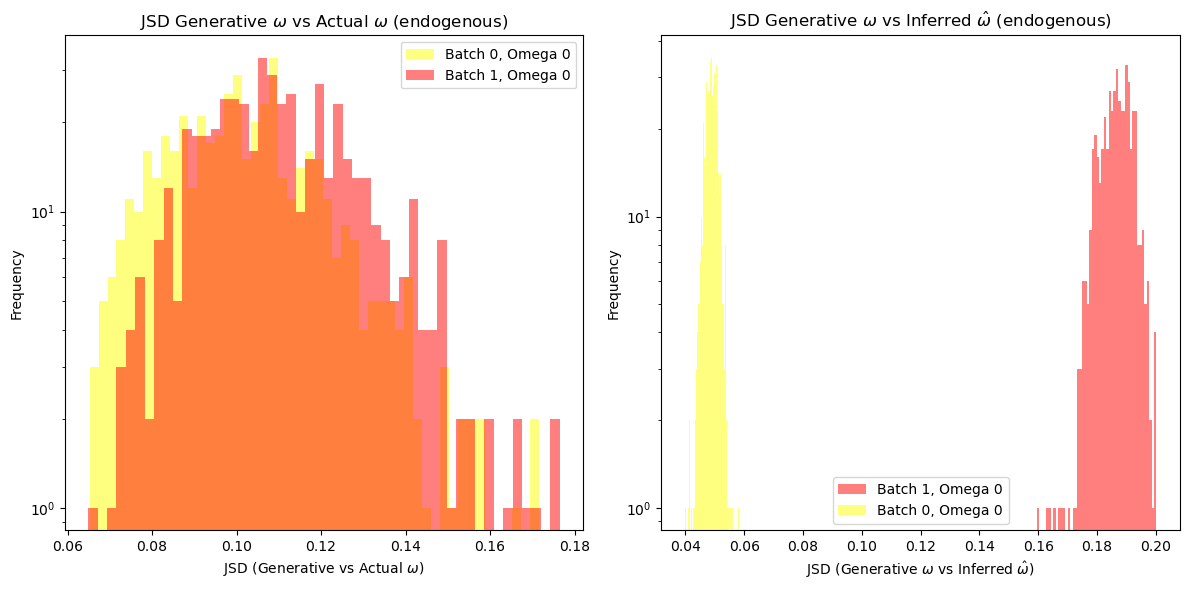

Inference Type:  inference_0


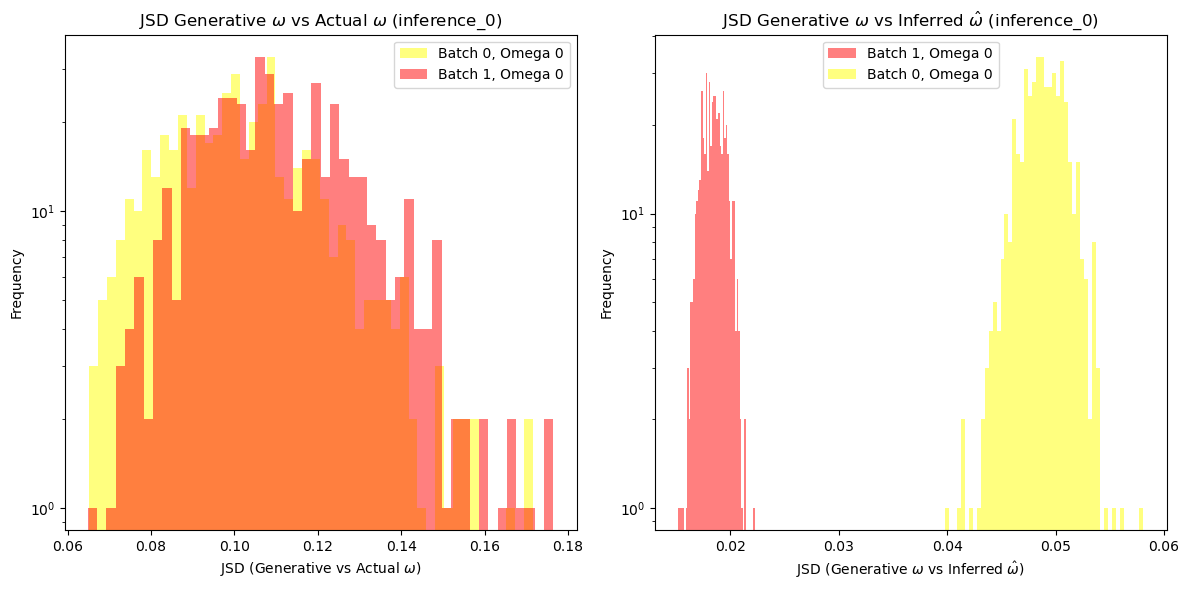

Inference Type:  endogenous


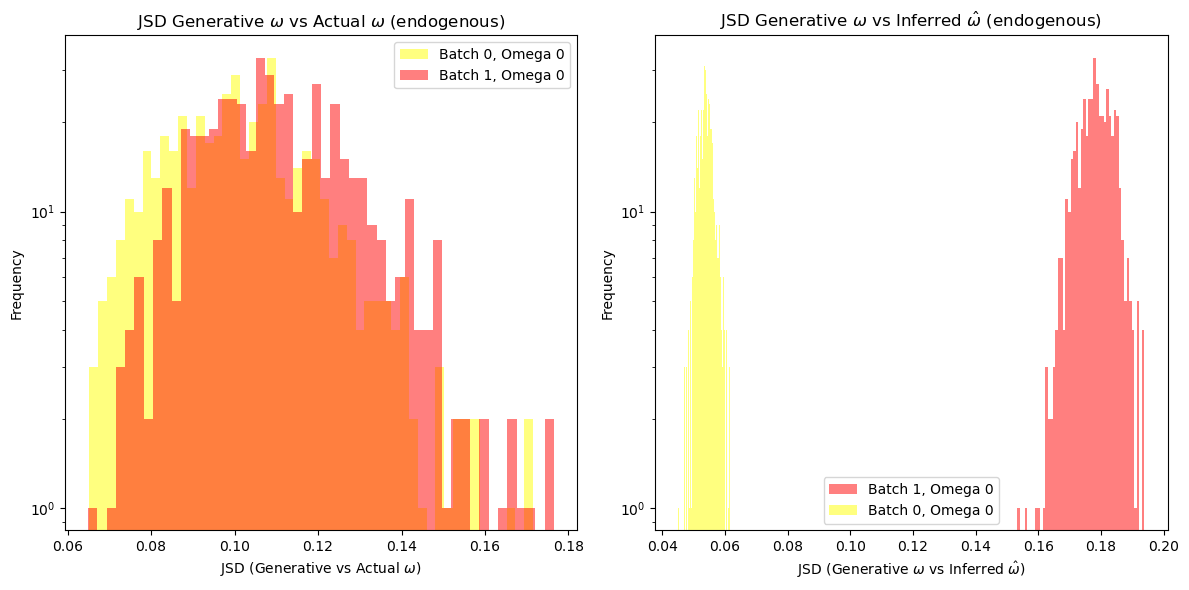

Inference Type:  inference_0


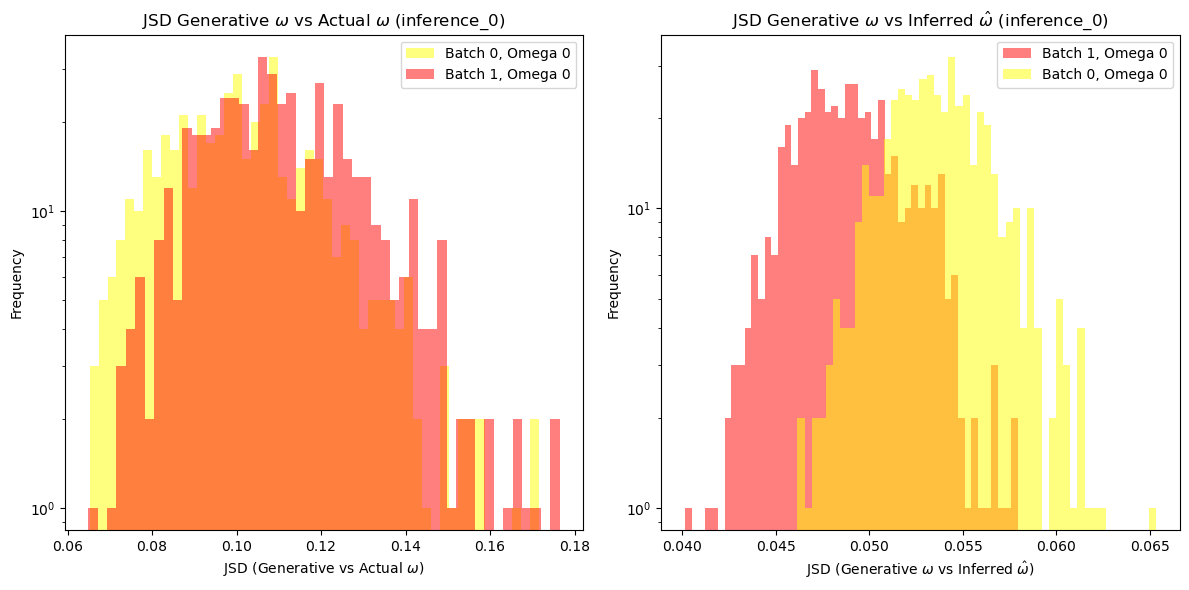

Inference Type:  endogenous


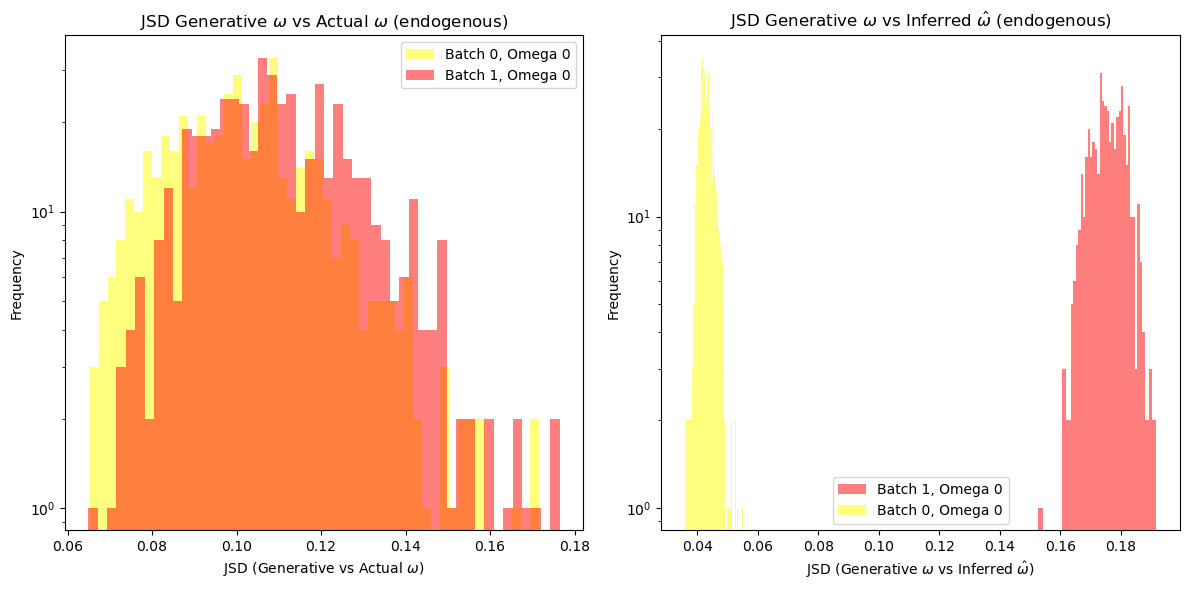

Inference Type:  inference_0


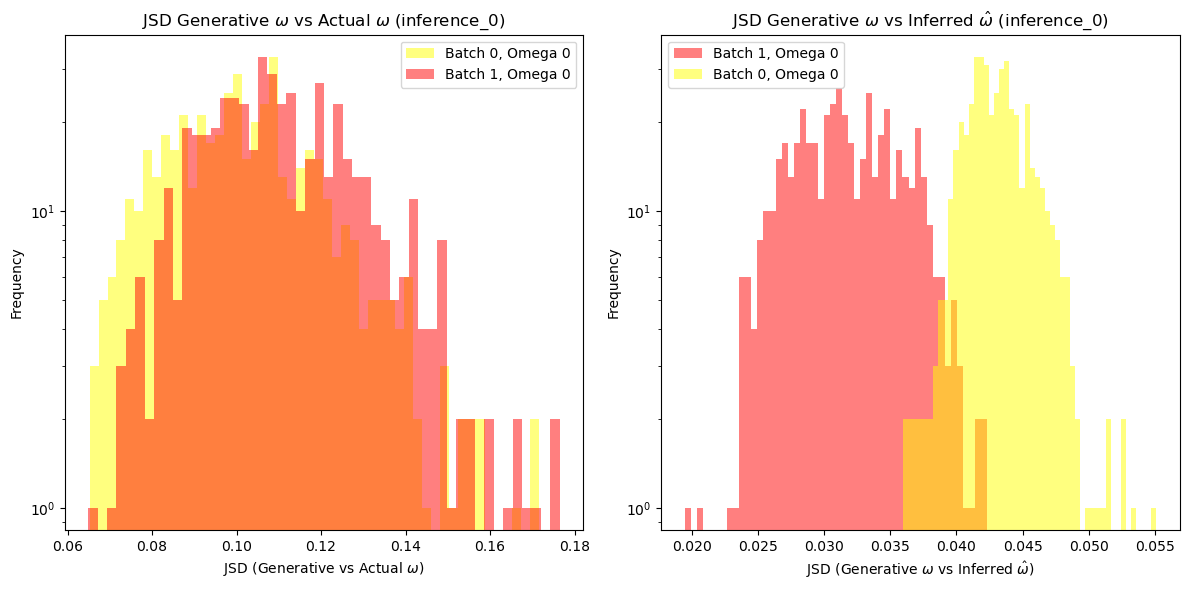

Inference Type:  endogenous


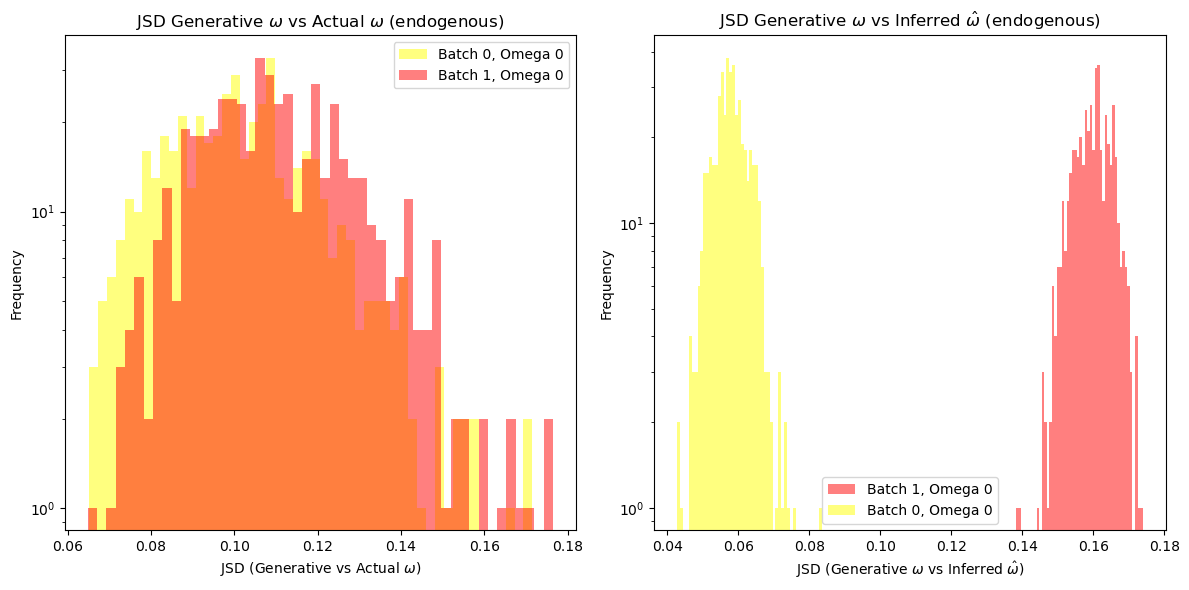

Inference Type:  inference_0


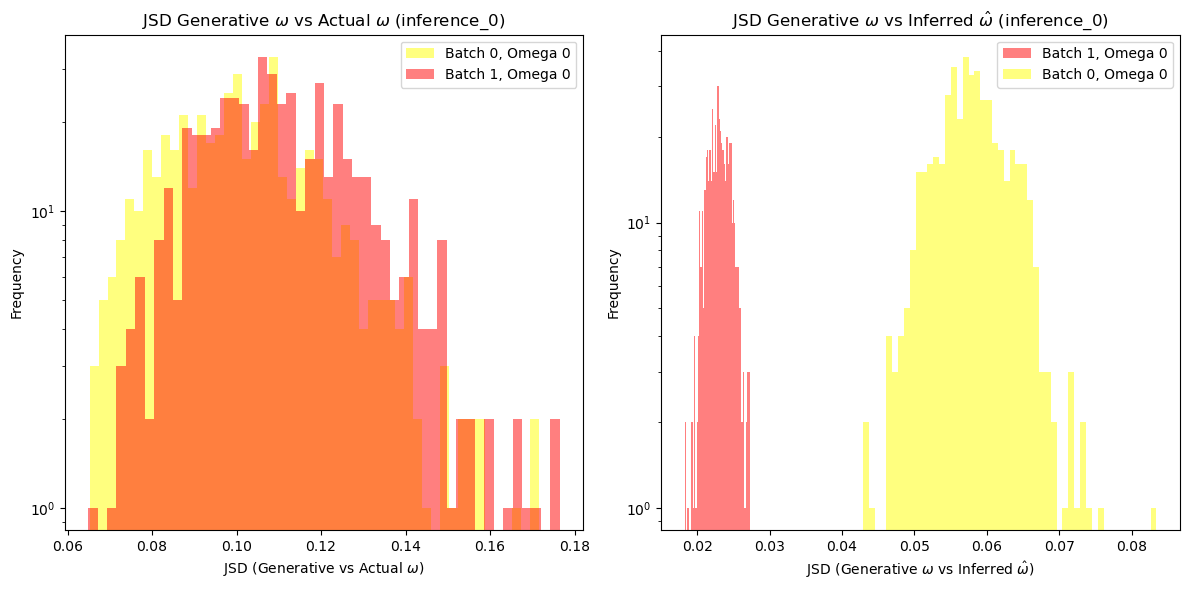

JSD of Omega Before/After Batch Adjustment (Batch 1 only)
Omega 0 Adj -0.1444 0.01548

JSD: Generated vs Inferred Omegas (Batch 0)
Omega 0 ToGen 0.05174 0.02029


In [6]:
diff_set_batch1_omega0, diff_set_batch1_omega1 = [], []
diff_set_batch0_omega0_to_gen, diff_set_batch0_omega1_to_gen = [], []

for pr_count, folder_name in enumerate(all_subfolders):

    jsd_omega_list = {}
    jsd_true_omega_list = {}

    for inf_type in infy[pr_count].inference_dict:

            if (inf_type == "inference_1"):
                break
            print("Inference Type: ", inf_type)
        
            inf_reinstate = infy[pr_count].inference_dict[inf_type]
            adata = inf_reinstate.return_counts_as_anndata()
                    
            # continuing on, lets pull Mu/Theta for this gene
            hat_mu = adata[0].X
            hat_theta = adata[0].layers["X_hat_theta"]
            true_counts = adata[0].layers["original_counts"]
                    
            # lets convert true counts to omega
            library_size = np.sum(true_counts, axis=1)

            # Calculate omega (proportion of library size for each gene)
            true_omega = true_counts / library_size[:, np.newaxis]
                            
            omega = adata[0].layers["px_omega"]

            batches = adata[0].obs['batch']
            omega_types = adata[0].obs['omega_type']

            true_omega_0 = adata[0].var['omega_0']
            true_omega_1 = adata[0].var['omega_1']

            gene_order = inf_reinstate.ds.gene_names

            batches = adata[0].obs['batch'].astype('category')
            categories = batches.cat.categories

            # Prepare the DataFrame for omega
            df_omega = pd.DataFrame(omega, columns=[f'gene_{i}' for i in range(omega.shape[1])])
            df_omega['Batch'] = batches.to_numpy()
            df_omega['Omega'] = omega_types.to_numpy()

            # Prepare the DataFrame for true_omega
            df_true_omega = pd.DataFrame(true_omega, columns=[f'gene_{i}' for i in range(true_omega.shape[1])])
            df_true_omega['Batch'] = batches.to_numpy()
            df_true_omega['Omega'] = omega_types.to_numpy()

            # Group by 'Batch' and 'Omega' without computing the mean
            grouped_omega = df_omega.groupby(['Batch', 'Omega'])
            grouped_true_omega = df_true_omega.groupby(['Batch', 'Omega'])

            # Get the unique combinations of 'Batch' and 'Omega'
            batch_values = df_omega['Batch'].unique()
            omega_values = df_omega['Omega'].unique()

            jsd_results_omega = {}
            jsd_results_true_omega = {}

            jsd_results_average = {}

            # now we want to compare the distribution of omegas by batch
            for batch in batch_values:
                for omega_type in omega_values:
                    
                        # Get the group for the current batch and omega
                        group_omega = grouped_omega.get_group((batch, omega_type)).T
                        # Remove 'Batch' and 'Omega' rows
                        group_omega = group_omega.drop(['Batch', 'Omega'], errors='ignore')


                        # Get the corresponding true omega group
                        group_true_omega = grouped_true_omega.get_group((batch, omega_type)).T
                        group_true_omega = group_true_omega.drop(['Batch', 'Omega'], errors='ignore')


                        group_omega_mean_disribution = group_omega.mean(axis=1)
                        group_true_omega_mean_disribution = group_true_omega.mean(axis=1)

                        if (omega_type == 1):
                            omega_to_compare = true_omega_1.copy()
                        else: 
                            omega_to_compare = true_omega_0.copy()

                        
                        true_jsd_scipy = compute_jsd_scipy(group_true_omega_mean_disribution, omega_to_compare)
                        inferred_jsd_scipy = compute_jsd_scipy(group_omega_mean_disribution, omega_to_compare)


                        jsd_omega = group_omega.apply(
                            lambda col: compute_jsd_scipy(col, omega_to_compare), axis=0
                        )
                        jsd_true_omega = group_true_omega.apply(
                        lambda col: compute_jsd_scipy(col, omega_to_compare), axis=0
                        )

                        jsd_results_omega[(batch, omega_type)] = jsd_omega
                        jsd_results_true_omega[(batch, omega_type)] = jsd_true_omega

                        jsd_results_average[(batch, omega_type, 0)] = round(true_jsd_scipy,5)
                        jsd_results_average[(batch, omega_type, 1)] = round(inferred_jsd_scipy, 5)

            num_bins = 50
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            axes[0].hist((jsd_results_true_omega[(0,0)]), bins=num_bins, alpha=0.5, label='Batch 0, Omega 0', color='yellow')
            axes[0].hist((jsd_results_true_omega[(1,0)]), bins=num_bins, alpha=0.5, label='Batch 1, Omega 0', color='red')

            if (len(omega_values) > 1):
                axes[0].hist((jsd_results_true_omega[(0,1)]), bins=num_bins, alpha=0.5, label='Batch 0, Omega 1', color='orange')
                axes[0].hist((jsd_results_true_omega[(1,1)]), bins=num_bins, alpha=0.5, label='Batch 1, Omega 1', color='blue')
            axes[0].set_xlabel(r'JSD (Generative vs Actual $\omega$)')
            axes[0].set_ylabel('Frequency')
            axes[0].set_yscale('log')

            axes[0].set_title(f'JSD Generative $\omega$ vs Actual $\omega$ ({inf_type})')
            axes[0].legend()

            # Plot histograms for the second gene

            axes[1].hist((jsd_results_omega[(1,0)]), bins=num_bins, alpha=0.5, label='Batch 1, Omega 0', color='red')
            axes[1].hist((jsd_results_omega[(0,0)]), bins=num_bins, alpha=0.5, label='Batch 0, Omega 0', color='yellow')

            if (len(omega_values) > 1):
                axes[1].hist((jsd_results_omega[(0,1)]), bins=num_bins, alpha=0.5, label='Batch 0, Omega 1', color='orange')
                axes[1].hist((jsd_results_omega[(1,1)]), bins=num_bins, alpha=0.5, label='Batch 1, Omega 1', color='blue')
            axes[1].set_xlabel(r'JSD (Generative $\omega$ vs Inferred $\hat{\omega}$)')
            axes[1].set_ylabel('Frequency')
            axes[1].set_yscale('log')

            axes[1].set_title(f'JSD Generative $\omega$ vs Inferred $\hat{{\omega}}$ ({inf_type})')
            axes[1].legend()

            # Adjust layout and display the plots
            plt.tight_layout()

            plot_name = 'JSD_Generated_and_Inferred_Both_Batches.' + inf_type + "." + folder_name + ".pdf"
            plt.savefig(image_save + '/' + plot_name)
            plt.show()
            
            # quick output of the results
            #print("True JSD Batch 0 Omega 0", np.round(np.mean(jsd_results_true_omega[(0,0)]), 5), np.round(np.std(jsd_results_true_omega[(0,0)]), 5))
            #print("True JSD Batch 1 Omega 0", np.round(np.mean(jsd_results_true_omega[(1,0)]), 5), np.round(np.std(jsd_results_true_omega[(1,0)]), 5))
            #print("True JSD Batch 0 Omega 1", np.round(np.mean(jsd_results_true_omega[(0,1)]), 5), np.round(np.std(jsd_results_true_omega[(0,1)]), 5))
            #print("True JSD Batch 0 Omega 0", np.round(np.mean(jsd_results_true_omega[(1,1)]), 5), np.round(np.std(jsd_results_true_omega[(1,1)]), 5))
            #print()
            #print("Inferred JSD Batch 0 Omega 0", np.round(np.mean(jsd_results_omega[(0,0)]), 5), np.round(np.std(jsd_results_omega[(0,0)]), 5))
            #print("Inferred JSD Batch 1 Omega 0", np.round(np.mean(jsd_results_omega[(1,0)]), 5), np.round(np.std(jsd_results_omega[(1,0)]), 5))
            #print("Inferred JSD Batch 0 Omega 1", np.round(np.mean(jsd_results_omega[(0,1)]), 5), np.round(np.std(jsd_results_omega[(0,1)]), 5))
            #print("Inferred JSD Batch 0 Omega 0", np.round(np.mean(jsd_results_omega[(1,1)]), 5) , np.round(np.std(jsd_results_omega[(1,1)]), 5))

            jsd_omega_list[inf_type] = jsd_results_omega
            jsd_true_omega_list[inf_type] = jsd_results_true_omega

            # okay I want to save the difference between the adjustments before and after
            # but that happens outside this loop, so I have to save all these results
    
    # we want the difference between Omega # Batch 1 (endogenous and inference_0), and the difference between
    
    diff_batch1_omega0 = jsd_omega_list['inference_0'][(1,0)] - jsd_omega_list['endogenous'][(1,0)]
    diff_set_batch1_omega0.extend(diff_batch1_omega0)
    # I also want to see the difference between batch 0 generated vs endogenous batch 0
    diff_batch0_omega0_to_gen = jsd_true_omega_list['endogenous'][(0,0)] - jsd_omega_list['endogenous'][(0,0)]
    diff_set_batch0_omega0_to_gen.extend(diff_batch0_omega0_to_gen)
    
    if (len(omega_values) > 1):
        diff_batch1_omega1 = jsd_omega_list['inference_0'][(1,1)] - jsd_omega_list['endogenous'][(1,1)]
        diff_set_batch1_omega1.extend(diff_batch1_omega1)
        diff_batch0_omega1_to_gen = jsd_true_omega_list['endogenous'][(0,1)] - jsd_omega_list['endogenous'][(0,1)]
        diff_set_batch0_omega1_to_gen.extend(diff_batch0_omega1_to_gen)
    

# Calculate the mean and stdev across all runs: Batch Adjustment
overall_std_omega0 = np.std(np.array(diff_set_batch1_omega0))
overall_mean_omega0 = np.mean(np.array(diff_set_batch1_omega0))
# Calculate the mean and stdev across all runs: Batch 0 - Generated Omega vs Inferred Omega
overall_std_omega0_togen = np.std(np.array(diff_set_batch0_omega0_to_gen))
overall_mean_omega0_togen = np.mean(np.array(diff_set_batch0_omega0_to_gen))

print("JSD of Omega Before/After Batch Adjustment (Batch 1 only)")
print("Omega 0 Adj", np.round(overall_mean_omega0, 5), np.round(overall_std_omega0, 5))

if (len(omega_values) > 1):
    overall_std_omega1 = np.std(diff_set_batch1_omega1)
    overall_mean_omega1 = np.mean(diff_set_batch1_omega1)
    print("Omega 1 Adj", np.round(overall_mean_omega1, 5), np.round(overall_std_omega1, 5))
    overall_std_omega1_togen = np.std(diff_set_batch0_omega1_to_gen)
    overall_mean_omega1_togen = np.mean(diff_set_batch0_omega1_to_gen)

print()
print("JSD: Generated vs Inferred Omegas (Batch 0)")
print("Omega 0 ToGen", np.round(overall_mean_omega0_togen, 5), np.round(overall_std_omega0_togen, 5))

if (len(omega_values) > 1):
    print("Omega 1 ToGen", np.round(overall_mean_omega1_togen, 5), np.round(overall_std_omega1_togen, 5))


For just 1 omega runs

50%)
SD of Omega Before/After Batch Adjustment (Batch 1 only)
Omega 0 Adj -0.11231 0.0303

JSD: Generated vs Inferred Omegas (Batch 0)
Omega 0 ToGen 0.03437 0.0234


60%
JSD of Omega Before/After Batch Adjustment (Batch 1 only)
Omega 0 Adj -0.08233 0.04737

JSD: Generated vs Inferred Omegas (Batch 0)
Omega 0 ToGen -0.0321 0.03504

70%
JSD of Omega Before/After Batch Adjustment (Batch 1 only)
Omega 0 Adj -0.08586 0.03834

JSD: Generated vs Inferred Omegas (Batch 0)
Omega 0 ToGen 0.04909 0.02185

80%
JSD of Omega Before/After Batch Adjustment (Batch 1 only)
Omega 0 Adj -0.08182 0.01331

JSD: Generated vs Inferred Omegas (Batch 0)
Omega 0 ToGen 0.0617 0.02005

90% (#4 kinda sucked, leading to the big stdev)
JSD of Omega Before/After Batch Adjustment (Batch 1 only)
Omega 0 Adj -0.1444 0.01548

JSD: Generated vs Inferred Omegas (Batch 0)
Omega 0 ToGen 0.05174 0.02029

100%
JSD of Omega Before/After Batch Adjustment (Batch 1 only)
Omega 0 Adj -0.0411 0.03992

JSD: Generated vs Inferred Omegas (Batch 0)
Omega 0 ToGen 0.0338 0.0243

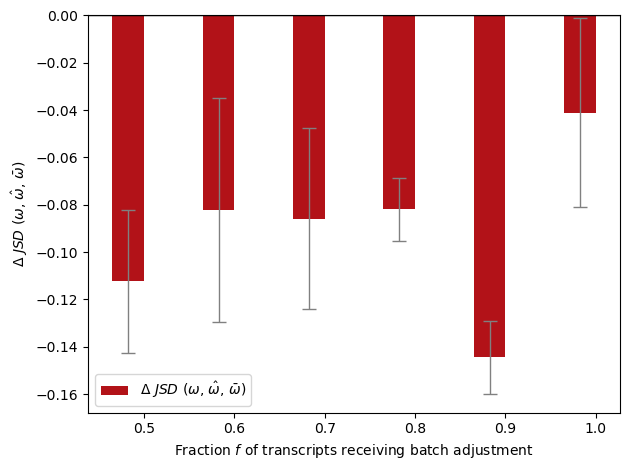

In [ ]:
# These numbers are from a fixed re-run where r_prime was set to 128 (accidentally left it at 25 after the PAM50 work)
# Re-run 4 times, and stdev over every patient
jsd_means_test3 = {
 'delta JSD Post-Batch Corr.': [-0.11231, -0.08233, -0.08586, -0.08182, -0.1444, -0.0411
                                ],
}

jsd_std_test3 = {
  'delta JSD Post-Batch Corr.': [0.0303, 0.04737, 0.03834, 0.01331, 0.01548, 0.03992],
}


# Define row names
row_names = ['0.5', '0.6', '0.7', '0.8', '0.9', '1.0']

# Create the DataFrame
df_means = pd.DataFrame(jsd_means_test3, index=row_names)
df_stds = pd.DataFrame(jsd_std_test3, index=row_names)

# Plotting
n_rows = len(df_means)
bar_width = 0.35
x = np.arange(n_rows)

# fixing colour scheme
cmap = sns.color_palette("Reds", as_cmap=True)
n_bars = len(jsd_means_test3)
colours = cmap(np.linspace(0.83, 0.83, 2))

fig, ax = plt.subplots()
error_params = dict(elinewidth=1, ecolor='grey', capsize=5)

ax.bar(x - bar_width/2, df_means['delta JSD Post-Batch Corr.'], width=bar_width,
       yerr=df_stds['delta JSD Post-Batch Corr.'], capsize=5, error_kw=error_params,
       label=r'$\Delta~JSD$ ($\omega$, $\hat{\omega}$, $\bar{\omega}$)', color=colours[1])


ax.axhline(y=0, color='black', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(row_names)
ax.set_xlabel(r'Fraction $f$ of transcripts receiving batch adjustment')
ax.set_ylabel(r'$\Delta~JSD$ ($\omega$, $\hat{\omega}$, $\bar{\omega}$)')
ax.legend()

write_path = "/path/to/3.1_omega_batch_dataset_jsd_only/single_omega_batch_adjustment.update.pdf"
plt.savefig(write_path)

plt.tight_layout()
plt.show()


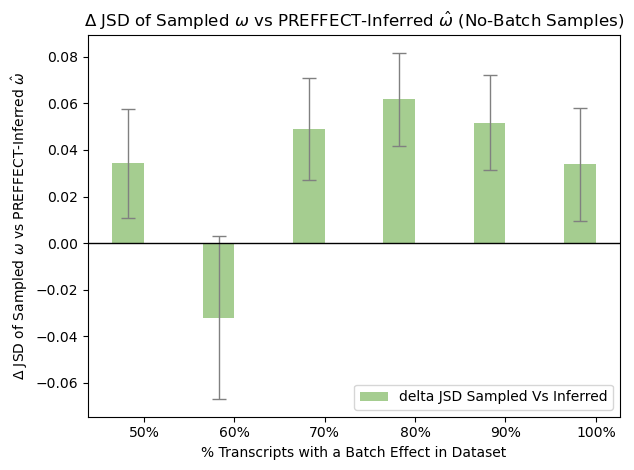

In [ ]:
# This is the difference between the generated omega JSD (to the generatIVE omega) and the inferred omega JSD in Batch 0 samples
jsd_means_test3 = {
   'delta JSD Sampled Vs Inferred': [0.03437, -0.0321, 0.04909, 0.0617, 0.05174, 0.0338 
                                ],

}


jsd_std_test3 = {
   'delta JSD Sampled Vs Inferred': [0.0234, 0.03504, 0.02185, 0.02005, 0.02029, 0.0243
                                ],

}

# Define row names
row_names = ['50%', '60%', '70%', '80%', '90%', '100%']

# Create the DataFrame
df_means = pd.DataFrame(jsd_means_test3, index=row_names)
df_stds = pd.DataFrame(jsd_std_test3, index=row_names)

# Plotting
n_rows = len(df_means)
bar_width = 0.35
x = np.arange(n_rows)

cmap = sns.color_palette("crest_r", as_cmap=True)
n_bars = len(jsd_means_test3)
colors = cmap(np.linspace(0, 1, 2))

fig, ax = plt.subplots()
error_params = dict(elinewidth=1, ecolor='grey', capsize=5)

ax.bar(x - bar_width/2, df_means['delta JSD Sampled Vs Inferred'], width=bar_width,
       yerr=df_stds['delta JSD Sampled Vs Inferred'], capsize=5, error_kw=error_params,
       label='delta JSD Sampled Vs Inferred', color=colors[1])

ax.axhline(y=0, color='black', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(row_names)
ax.set_xlabel('% Transcripts with a Batch Effect in Dataset')
ax.set_ylabel(r'$\Delta$ JSD of Sampled $\omega$ vs PREFFECT-Inferred $\hat{\omega}$')
ax.set_title(r'$\Delta$ JSD of Sampled $\omega$ vs PREFFECT-Inferred $\hat{\omega}$ (No-Batch Samples)')
ax.legend()

write_path = "/path/to/3.1_omega_batch_dataset_jsd_only/single_omega_jsd_compare_sampled_inferred.pdf"
plt.savefig(write_path)

plt.tight_layout()
plt.show()

I re-ran above to gather the results of the runs at 50%, 60%, etc.

Delta JSD: Before and After Batch Adjustment (Batch 1): Multi Omega Results (multiple runs)
50%
Omega 0 Adj -0.15285 0.075106
Omega 1 Adj -0.064001 0.010842
60%
Omega 0 Adj -0.11376 0.026311
Omega 1 Adj -0.19254 0.028047
70%
Omega 0 Adj -0.12387 0.022555
Omega 1 Adj -0.073765 0.062261
80%
Omega 0 Adj -0.1363 0.04254
Omega 1 Adj -0.12227 0.07936
90%
Omega 0 Adj -0.1189 0.02142
Omega 1 Adj -0.07863 0.04503
100%
Omega 0 Adj 0.04402 0.12678
Omega 1 Adj 0.03374 0.06546

4 datapoints: 
50%
Omega 0 Adj -0.17292 0.0738
Omega 1 Adj -0.05829 0.01412
60%
Omega 0 Adj -0.11597 0.02381
Omega 1 Adj -0.19004 0.02473
70%
Omega 0 Adj -0.11693 0.02297
Omega 1 Adj -0.08246 0.05604
80%
Omega 0 Adj -0.13155 0.03789
Omega 1 Adj -0.12223 0.06851
90%
Omega 0 Adj -0.0882 0.05638
Omega 1 Adj -0.07789 0.03912
100%
Omega 0 Adj -0.08644 0.078
Omega 1 Adj -0.10168 0.12571

5-Runs

50%
Omega 0 Adj -0.17024 0.06628
Omega 1 Adj -0.03132 0.05595

60%
Omega 0 Adj -0.11688 0.0216
Omega 1 Adj -0.19741 0.02667

70% 
Omega 0 Adj -0.11344 0.02181
Omega 1 Adj -0.08909 0.05193

80%
Omega 0 Adj -0.1326 0.03404
Omega 1 Adj -0.14607 0.07797


90%
Omega 0 Adj -0.09765 0.05389
Omega 1 Adj -0.09509 0.04912

100%
Omega 0 Adj -0.08509 0.07011
Omega 1 Adj -0.06963 0.12956

Delta JSD: Generated/Sampled Vs Endogenous (Batch 0): Multi Omega Results (multiple runs)

50%
Omega 0 ToGen -0.086327 0.051169
Omega 1 ToGen 0.035090 0.0242365
60% 
Omega 0 ToGen 0.052486 0.020366
Omega 1 ToGen 0.0192086 0.043697
70%
Omega 0 ToGen 0.033740 0.025445
Omega 1 ToGen 0.058763 0.023923
80%
Omega 0 ToGen 0.01069 0.03193
Omega 1 ToGen -0.01648 0.0394
90%
Omega 0 ToGen 0.06677 0.02329
Omega 1 ToGen 0.0559 0.02867
100%
Omega 0 ToGen -0.04569 0.04485
Omega 1 ToGen 0.03271 0.03309

4 data points:

50%
Omega 0 ToGen -0.08607 0.04827
Omega 1 ToGen 0.02931 0.02591
60%
Omega 0 ToGen 0.05866 0.02264
Omega 1 ToGen 0.0116 0.04366
70%
Omega 0 ToGen 0.02881 0.02667
Omega 1 ToGen 0.06034 0.02294
80%
Omega 0 ToGen 0.00988 0.03208
Omega 1 ToGen -0.02181 0.03925
90%
Omega 0 ToGen 0.06642 0.02266
Omega 1 ToGen 0.05259 0.02769
100%
Omega 0 ToGen -0.02558 0.03839
Omega 1 ToGen 0.02601 0.03455


5 Runs:

50%
Omega 0 ToGen -0.07995 0.04771
Omega 1 ToGen 0.03011 0.0252

60%
Omega 0 ToGen 0.05752 0.02209
Omega 1 ToGen 0.00767 0.0428


70%
Omega 0 ToGen 0.03112 0.02641
Omega 1 ToGen 0.0639 0.02321

80%
Omega 0 ToGen 0.00337 0.03472
Omega 1 ToGen -0.01712 0.03904

90%
Omega 0 ToGen 0.06687 0.02218
Omega 1 ToGen 0.05659 0.02771

100%

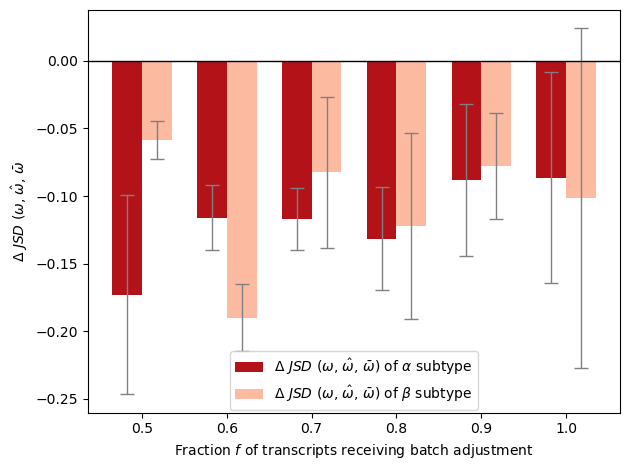

In [ ]:
# These numbers are from a fixed re-run where r_prime was set to 128 (accidentally left it at 25 after the PAM50 work)
# Re-run 4 times, and stdev over every patient
jsd_means_test3 = {
 # 3 models   'Batch Corrected Omega 0': [-0.15285, -0.11376, -0.12387, -0.1363, -0.1189, 0.04402
 'delta JSD Post-Batch Corr. Subtype 0': [-0.17292, -0.11597, -0.11693, -0.13155, -0.0882, -0.08644
                                ],

 # 3 models  'Batch Corrected Omega 1': [-0.064001,-0.19254, -0.073765, -0.12227, -0.07863, 0.03374
  'delta JSD Post-Batch Corr. Subtype 1': [-0.05829, -0.19004, -0.08246, -0.12223, -0.07789, -0.10168
                                ],
}

jsd_std_test3 = {
  # 3 models   'Batch Corrected Omega 0': [0.075106, 0.026311, 0.022555, 0.04254, 0.02142, 0.12678],
  'delta JSD Post-Batch Corr. Subtype 0': [0.0738, 0.02381, 0.02297, 0.03789, 0.05638, 0.078],

   # 3 models  'Batch Corrected Omega 1': [0.010842, 0.028047, 0.062261, 0.07936, 0.04503, 0.06546],
   'delta JSD Post-Batch Corr. Subtype 1': [0.01412, 0.02473, 0.05604, 0.06851, 0.03912, 0.12571],
}



# Define row names
row_names = ['0.5', '0.6', '0.7', '0.8', '0.9', '1.0']

# Create the DataFrame
df_means = pd.DataFrame(jsd_means_test3, index=row_names)
df_stds = pd.DataFrame(jsd_std_test3, index=row_names)

# Plotting
n_rows = len(df_means)
bar_width = 0.35
x = np.arange(n_rows)

# fixing colour scheme
cmap = sns.color_palette("Reds", as_cmap=True)
n_bars = len(jsd_means_test3)
colours = cmap(np.linspace(0.83, 0.25, n_bars))

fig, ax = plt.subplots()
error_params = dict(elinewidth=1, ecolor='grey', capsize=5)

ax.bar(x - bar_width/2, df_means['delta JSD Post-Batch Corr. Subtype 0'], width=bar_width,
       yerr=df_stds['delta JSD Post-Batch Corr. Subtype 0'], capsize=5, error_kw=error_params,
       label=r'$\Delta~JSD$ ($\omega$, $\hat{\omega}$, $\bar{\omega}$) of $\alpha$ subtype', color=colours[0])

ax.bar(x + bar_width/2, df_means['delta JSD Post-Batch Corr. Subtype 1'], width=bar_width,
       yerr=df_stds['delta JSD Post-Batch Corr. Subtype 1'], capsize=5, error_kw=error_params,
       label=r'$\Delta~JSD$ ($\omega$, $\hat{\omega}$, $\bar{\omega}$) of $\beta$ subtype', color=colours[1])

ax.axhline(y=0, color='black', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(row_names)
ax.set_xlabel(r'Fraction $f$ of transcripts receiving batch adjustment')
ax.set_ylabel(r'$\Delta~JSD$ ($\omega$, $\hat{\omega}$, $\bar{\omega}$')
#ax.set_title(r'$\Delta$ JSD (Generative $\omega$ vs Inferred $\hat{\omega}$) from Batch Correction')


ax.legend(
    loc='center', 
    bbox_to_anchor=(0.5, 0.08),  # (x, y) position from bottom-left
    ncol=1,                     # number of columns (optional)
    frameon=True                # whether to draw a frame
)

#ax.legend()

write_path = "/path/to/3.1_omega_batch_dataset_jsd_only/dual_omega_jsd_batch_correction.update.pdf"
plt.savefig(write_path)

plt.tight_layout()
plt.show()


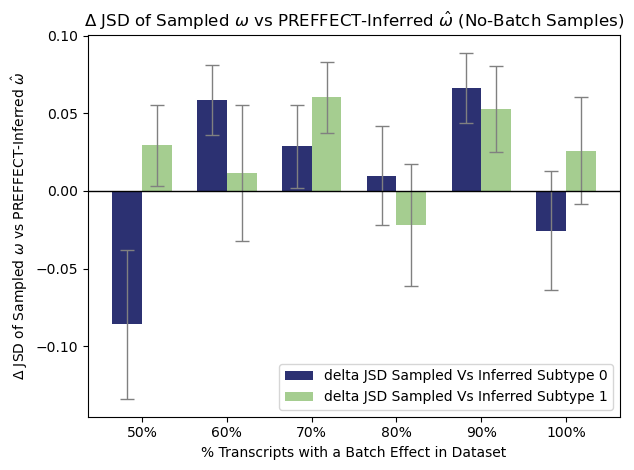

In [ ]:
# This is the difference between the generated omega JSD (to the generatIVE omega) and the inferred omega JSD in Batch 0 samples
jsd_means_test3 = {
   # 3 models 'JSD Gen Vs Inf Omega 0': [-0.086327, 0.052486, 0.033740, 0.01069, 0.06677, -0.04569
   'delta JSD Sampled Vs Inferred Subtype 0': [-0.08607, 0.05866, 0.02881, 0.00988, 0.06642, -0.02558
                                ],

   # 3 models 'JSD Gen Vs Inf Omega 1': [0.035090, 0.0192086, 0.058763, -0.01648, 0.0559, 0.03271
   'delta JSD Sampled Vs Inferred Subtype 1': [0.02931, 0.0116, 0.06034, -0.02181, 0.05259, 0.02601
                                ],
}


jsd_std_test3 = {
  # 3 models  'JSD Gen Vs Inf Omega 0': [0.051169, 0.020366, 0.025445, 0.03193, 0.02329, 0.04485],
  'delta JSD Sampled Vs Inferred Subtype 0': [0.04827, 0.02264, 0.02667, 0.03208, 0.02266, 0.03839],

  # 3 models  'JSD Gen Vs Inf Omega 1': [0.0242365, 0.043697, 0.023923, 0.0394, 0.02867, 0.03309],
  'delta JSD Sampled Vs Inferred Subtype 1': [0.02591, 0.04366, 0.02294, 0.03925, 0.02769, 0.03455],
}


# Define row names
row_names = ['50%', '60%', '70%', '80%', '90%', '100%']

# Create the DataFrame
df_means = pd.DataFrame(jsd_means_test3, index=row_names)
df_stds = pd.DataFrame(jsd_std_test3, index=row_names)

# Plotting
n_rows = len(df_means)
bar_width = 0.35
x = np.arange(n_rows)

cmap = sns.color_palette("crest_r", as_cmap=True)
n_bars = len(jsd_means_test3)
colors = cmap(np.linspace(0, 1, n_bars))



fig, ax = plt.subplots()
error_params = dict(elinewidth=1, ecolor='grey', capsize=5)

ax.bar(x - bar_width/2, df_means['delta JSD Sampled Vs Inferred Subtype 0'], width=bar_width,
       yerr=df_stds['delta JSD Sampled Vs Inferred Subtype 0'], capsize=5, error_kw=error_params,
       label='delta JSD Sampled Vs Inferred Subtype 0', color=colors[0])

ax.bar(x + bar_width/2, df_means['delta JSD Sampled Vs Inferred Subtype 1'], width=bar_width,
       yerr=df_stds['delta JSD Sampled Vs Inferred Subtype 1'], capsize=5, error_kw=error_params, 
       label='delta JSD Sampled Vs Inferred Subtype 1', color=colors[1])
ax.axhline(y=0, color='black', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(row_names)
ax.set_xlabel('% Transcripts with a Batch Effect in Dataset')
ax.set_ylabel(r'$\Delta$ JSD of Sampled $\omega$ vs PREFFECT-Inferred $\hat{\omega}$')
ax.set_title(r'$\Delta$ JSD of Sampled $\omega$ vs PREFFECT-Inferred $\hat{\omega}$ (No-Batch Samples)')
ax.legend()

write_path = "/path/to/3.1_omega_batch_dataset_jsd_only/dual_omega_jsd_sampled_inferred.pdf"
plt.savefig(write_path)


plt.tight_layout()
plt.show()